In [10]:
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import plotly.express as px

warnings.filterwarnings("ignore")

def get_data():
    df = pd.read_csv("Test Data Set.csv",index_col=0)
    df['Dates'] = pd.to_datetime(df['Dates'],dayfirst=True)
    df.set_index("Dates",inplace=True)
    df = df.dropna(how="any")
    return df
df = get_data()

# Exploration

In [20]:
def plots(df):
    fig = px.line(df)
    fig.show()
plots(df)

# Answers

A. Please look at relationships between A_1 and A_2 as well as A_1 and A_3. Please do this for date range between 1st of Jan and 30th of Sep for a given calendar year. Are there any periods within this time frame when the relationships change significantly?

Pearson corelation: 0.04
Spearman corelation: 0.037



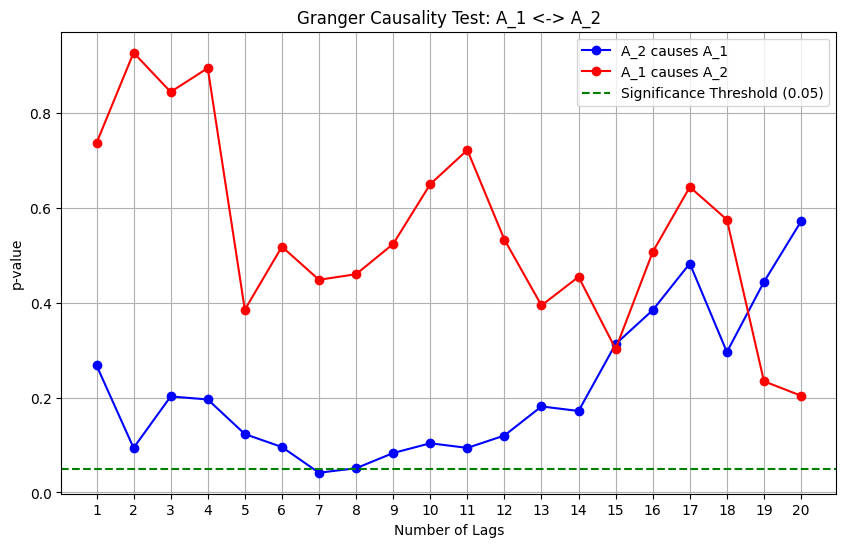

Pearson corelation: 0.104
Spearman corelation: 0.051



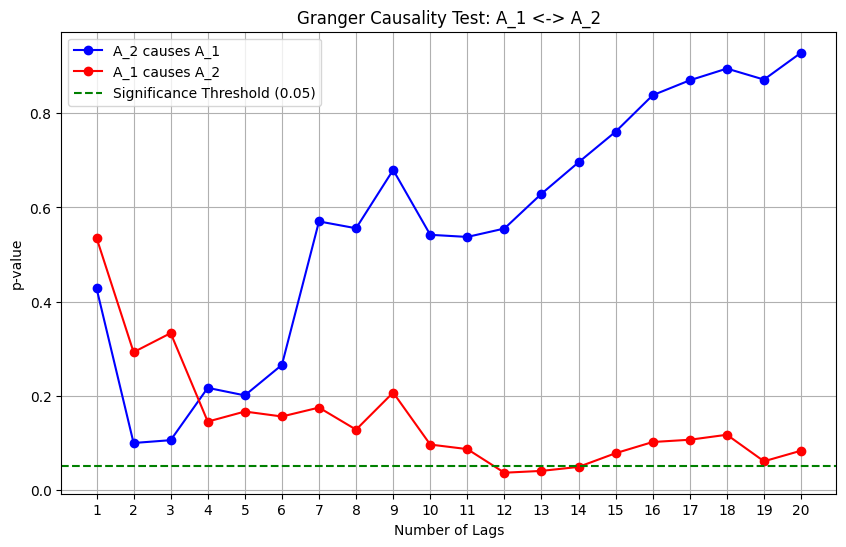

Pearson corelation: 0.097
Spearman corelation: 0.079



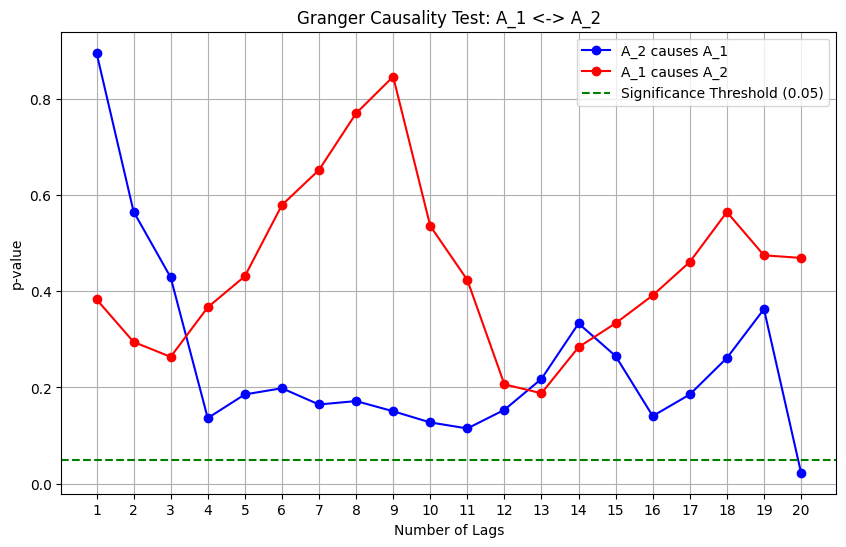

In [66]:
def year_split(df):
    yrs = df.index.year.unique()
    dfs = []

    for yr in yrs:
        temp = df[df.index.year == yr]
        end_date = f"{list(temp.index.year)[0]}-09-30"
        filtered_yr = temp[temp.index <= end_date]
        dfs.append(filtered_yr)

    return dfs

def corr_plot(df):
    f = plt.figure(figsize=(12,8))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)


import plotly.graph_objs as go
from plotly.subplots import make_subplots

def rolling_covariance_plot(df, col1, col2, window=12):
    # Calculate the rolling covariance
    rolling_cov = df[col1].rolling(window=window).cov(df[col2])
    
    # Create a Plotly figure
    fig = go.Figure()
    
    # Add a trace for rolling covariance
    fig.add_trace(go.Scatter(x=df.index, y=rolling_cov, mode='lines', name='Rolling Covariance', line=dict(color='blue')))
    
    # Update layout
    fig.update_layout(title=f'Rolling Covariance between {col1} and {col2}',
                      xaxis_title='Date',
                      yaxis_title='Rolling Covariance',
                      showlegend=True)
    
    # Show the interactive plot
    fig.show()

import plotly.express as px
import plotly.graph_objects as go

def rolling_cointegration_analysis(yr, col1, col2, window_size=30, significance_threshold=0.05):
    cointegration_results = pd.DataFrame(columns=['Start Date', 'End Date', 'P-value'])

    p_values = []
    start_dates = []
    end_dates = []

    for i in range(len(yr) - window_size + 1):
        window_data = yr.iloc[i:i+window_size] 
        result = coint(window_data[col1], window_data[col2])

        cointegration_results = cointegration_results.append({
            'Start Date': window_data.index[0],
            'End Date': window_data.index[-1],
            'P-value': result[1]
        }, ignore_index=True)

        p_values.append(result[1])
        start_dates.append(window_data.index[0])
        end_dates.append(window_data.index[-1])

    significant_results = cointegration_results[cointegration_results['P-value'] < significance_threshold]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=start_dates, y=p_values, mode='lines', name='P-value'))
    fig.add_shape(
        type='line',
        x0=min(start_dates),
        x1=max(start_dates),
        y0=significance_threshold,
        y1=significance_threshold,
        line=dict(color='red', dash='dash'),
        name=f'Significance Threshold ({significance_threshold})'
    )

    fig.update_layout(
        title=f'Rolling Cointegration Analysis ({col1} vs {col2})',
        xaxis_title='Time',
        yaxis_title='P-value',
        showlegend=True,
        grid=dict(rows=1, columns=1, pattern='independent', xaxes=['x'], yaxes=['y'], xgap=0.2, ygap=0.3),
    )

    fig.show()

def relationship_test(df,var1,var2):
    pearsoncorr, _ = pearsonr(df[var1], df[var2])
    print(f"Pearson corelation: {round(pearsoncorr,3)}")
    spearmancorr, _ = spearmanr(df[var1], df[var2])
    print(f"Spearman corelation: {round(spearmancorr,3)}\n")

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

def granger_causality_test_and_plot_both_directions(df, column1, column2, max_lags=20, significance_threshold=0.05):
    """
    Perform Granger causality test and plot p-values for two columns in both directions.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column1 (str): Name of the first column for Granger causality.
        column2 (str): Name of the second column for Granger causality.
        max_lags (int): Maximum number of lags to test (default is 10).
        significance_threshold (float): Significance threshold for p-values (default is 0.05).

    Returns:
        None (plots the results).
    """
    # Initialize lists to store p-values for both directions
    p_values1_to_2 = []
    p_values2_to_1 = []

    # Perform Granger causality test for lags from 1 to max_lags in both directions
    for lag in range(1, max_lags + 1):
        # Create a DataFrame with the selected columns
        data = df[[column1, column2]]
        
        # Granger causality test in the direction of column1 -> column2
        test_result1_to_2 = sm.tsa.stattools.grangercausalitytests(data, maxlag=lag, verbose=False)
        p_value1_to_2 = test_result1_to_2[lag][0]['ssr_ftest'][1]
        p_values1_to_2.append(p_value1_to_2)
        
        # Granger causality test in the direction of column2 -> column1
        data = df[[column2, column1]]  # Swap the order for the second test
        test_result2_to_1 = sm.tsa.stattools.grangercausalitytests(data, maxlag=lag, verbose=False)
        p_value2_to_1 = test_result2_to_1[lag][0]['ssr_ftest'][1]
        p_values2_to_1.append(p_value2_to_1)

    # Create a line plot to visualize p-values for both directions
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_lags + 1), p_values1_to_2, marker='o', linestyle='-', color='b', label=f'{column2} causes {column1}')
    plt.plot(range(1, max_lags + 1), p_values2_to_1, marker='o', linestyle='-', color='r', label=f'{column1} causes {column2}')
    plt.axhline(y=significance_threshold, color='g', linestyle='--', label=f'Significance Threshold ({significance_threshold})')
    plt.title(f'Granger Causality Test: {column1} <-> {column2}')
    plt.xlabel('Number of Lags')
    plt.ylabel('p-value')
    plt.grid(True)
    plt.xticks(range(1, max_lags + 1))
    plt.legend()
    plt.show()

# Example usage:
# Assuming you have a DataFrame 'df' with columns 'A_1' and 'A_2'



yrs = year_split(df)
for yr in yrs:
    yr = yr[['A_1','A_2','A_3']]
    # plots(yr)
    rolling_covariance_plot(yr,'A_1', 'A_2', window=20)
    rolling_cointegration_analysis(yr, 'A_1', 'A_2', window_size=30)
    relationship_test(yr, 'A_1', 'A_2')
    granger_causality_test_and_plot_both_directions(yr, 'A_1', 'A_2')



B. Please look at relationship between A_4 and A_5 as well as A_4 and A_6.

C. If there is anything at all that you can deduce from the data set, please highlight it.